## Load libraries

In [1]:
library(RColorBrewer)
library(plyr)
library(dplyr)
library(ggplot2)
library(reshape)
library(reshape2)
library(tidyverse)
library(data.table)
library(repr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:plyr’:

    rename, round_any



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────

## Set paths to reference files

In [2]:
cancers=c('ccRCC','CRC','CESC','HNSCC','UCEC','GBM','BRCA','OV','MM','PDAC','SKCM')

#ATAC project color scales
path_to_ATAC_colors='../data/Colors_panatac_v2.0.rds'

#ATAC catalog
path_to_ATAC_catalog='../data/ATAC_catalog.20220114.v2.txt'

#Matrix with accessibility averaged per tumor cells from each sample, and per normal cells from tissue
path_to_ATAC_average_matrix='../data/snATAC/Average_accessibility_matrix.DataSlot.20230212.tsv'

#Cell counts per each cell group in matrix with average ATAC accessibility
path_to_ATAC_average_matrix_meta='../data/snATAC/Cell_count_perGroup.forAverageAccessibilityMatrix.20230212.tsv'

#TP53 mutation status based on bulk
path_to_tp53_mut_table='../data/snATAC/mut.cnv.tp53.bulk.category.042723.v2.txt'

#TP53 peaks supported by ChIP-seq, and that also contain TP53 binding motif
path_to_tp53_peaks='../data/snATAC/TP53_peaks_supported_ChipSeq.20230420.tsv'

In [3]:
cat=read_delim(path_to_ATAC_catalog,delim='\t',show_col_types = FALSE)
cat=as.data.frame(cat)
colnames(cat)=gsub(' ','_',colnames(cat))

cat$Piece_ID=paste(cat$Disease_Type,cat$Piece_ID,sep='_')
cat=cat %>% dplyr::select ('Piece_ID','Sample_Type')
colnames(cat)[2]=c('Sample_type')

In [4]:
tab_1=fread(path_to_ATAC_average_matrix)
tab_1=as.data.frame(tab_1)
rownames(tab_1)=tab_1[,1]
tab_1=tab_1[,-1]
tab_1=tab_1[,grepl('^Tumor_',colnames(tab_1))]
tab_2=t(tab_1)
tab=tab_2

meta=read.table(path_to_ATAC_average_matrix_meta,sep='\t',header=T)

#201 tumor samples.
meta_s=meta[meta$Cell_count>=20,]
colnames(tab)=gsub('\\.','-',colnames(tab))
tab=tab[rownames(tab) %in% meta_s$Cell_type,]

Warning message in fread(path_to_ATAC_average_matrix):
“Detected 245 column names but the data has 246 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [5]:
row_annot=as.data.frame(rownames(tab))
colnames(row_annot)='ID'
row_annot$Cell_type=gsub('(.*)__(.*)_(.*)','\\1',row_annot$ID)
row_annot$Disease=gsub('(.*)__(.*)_(.*)','\\2',row_annot$ID)
row_annot$Piece_ID=gsub('Tumor__','',row_annot$ID)
row_annot$Disease=gsub('(.*)_.*','\\1',row_annot$Disease)

row_annot$Disease=ifelse(row_annot$Piece_ID %in% 
                         paste('BRCA',c("HT029B1-S1PC","HT035B1-S1PA","HT141B1-S1H1","HT206B1-S1H4","HT1408-06",
                                        "HT268B1-Th1H3","HT271B1-S1H3","HT378B1-S1H1", "HT378B1-S1H2", 
                                        "HT384B1-S1H1", "HT517B1-S1H1"),sep='_'),'BRCA_Basal',row_annot$Disease)

row_annot$Cell_type=ifelse(row_annot$Cell_type=='Tumor_OV','Tumor',row_annot$Cell_type)
row_annot$ID_2=paste(row_annot$Disease,row_annot$Cell_type,sep='_')
rownames(row_annot)=row_annot$ID

row_annot=merge(row_annot, cat,all.x=T)
rownames(row_annot)=row_annot$ID

In [6]:
mut=read.table(path_to_tp53_mut_table,sep='\t',header=T)

cat=read_delim(path_to_ATAC_catalog,delim='\t',show_col_types = FALSE)
cat=as.data.frame(cat)
colnames(cat)=gsub(' ','_',colnames(cat))

cat=cat %>% dplyr::select ('Piece_ID','Disease_Type')

In [7]:
colnames(mut)[2]='Piece_ID'
mut=merge(mut,cat)

mut=mut[mut$Classification %in% c('Truncation','WT','Missense'),]

mut$Cohort=mut$Disease_Type
mut$Cohort=ifelse(mut$Piece_ID %in% c("HT029B1-S1PC","HT035B1-S1PA","HT141B1-S1H1","HT206B1-S1H4",
                                      "HT1408-06","HT268B1-Th1H3","HT271B1-S1H3","HT378B1-S1H1", 
                                      "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1"), 'BRCA_Basal',mut$Cohort)


cancers=unique(mut$Disease_Type[mut$Classification!='WT'])

mut$Piece_ID_1=paste(mut$Disease_Type, mut$Piece_ID,sep='_')
row_annot_1=row_annot[row_annot$Piece_ID %in% mut$Piece_ID_1,]
tab_1=tab[row_annot_1$ID,]

In [8]:
dacrs_m=read_delim(path_to_tp53_peaks,delim='\t',show_col_types = FALSE)
dacrs_m=as.data.frame(dacrs_m)
dacrs_m=dacrs_m[!duplicated(dacrs_m$peak),]
dacrs_m1=dacrs_m[,c('peak','Gene')]

tab_s=tab_1[,dacrs_m$peak]
rownames(tab_s)=row_annot_1$Piece_ID
tab_s1=reshape2::melt(tab_s)
colnames(tab_s1)=c('Piece_ID','peak','Accessibility')
r_a=row_annot_1[,c('Piece_ID','Disease')]
tab_s1=merge(tab_s1,r_a,all.x=T)
tab_s2=merge(tab_s1,dacrs_m1,all.x=T)

mut_s=mut[,c('Classification','Piece_ID_1')]
colnames(mut_s)[2]='Piece_ID'


tab_s3=merge(tab_s2,mut_s)

In [9]:
tab_s4=tab_s3
tab_s4$Disease=ifelse(tab_s4$Disease=='BRCA_Basal','BRCA',tab_s4$Disease)

cancers_t=c('BRCA')
cancers_m=c('BRCA')

all_st_all=NULL

In [10]:
#TP53 truncation vs WT
for (can in cancers_t){
    all_st=NULL
    tab_c=tab_s4[tab_s4$Disease==can,]
    for(peak in unique(tab_c$peak)){
        tab_c1=tab_c[tab_c$peak==peak,]
        gene=unique(tab_c1$Gene)
        mut_g=tab_c1$Accessibility[tab_c1$Classification=='Truncation']
        wt_g=tab_c1$Accessibility[tab_c1$Classification=='WT']
        if(length(mut_g)>=5 & length(wt_g)>=5){
        w_test=wilcox.test(mut_g,wt_g)
        fch=mean(mut_g)/mean(wt_g)
        st=cbind(peak,can,gene,w_test$p.value,fch)
        all_st=rbind(all_st,st)
    }
    }
all_st=as.data.frame(all_st)
colnames(all_st)=c('peak','Cancer','Gene','P','Fch')
all_st$FDR=p.adjust(all_st$P,method='fdr')

all_st_all=rbind(all_st_all,all_st)	
}
all_st_all$Type='Truncation'
all_st_all_t=all_st_all

Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot

Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot

In [11]:
#TP53 missense vs WT
all_st_all=NULL
for (can in cancers_m){
    all_st=NULL
    tab_c=tab_s4[tab_s4$Disease==can,]
    for(peak in unique(tab_c$peak)){
        tab_c1=tab_c[tab_c$peak==peak,]
        gene=unique(tab_c1$Gene)
        mut_g=tab_c1$Accessibility[tab_c1$Classification=='Missense']
        wt_g=tab_c1$Accessibility[tab_c1$Classification=='WT']
        if(length(mut_g)>=5 & length(wt_g)>=5){
        w_test=wilcox.test(mut_g,wt_g)
        fch=mean(mut_g)/mean(wt_g)
        st=cbind(peak,can,gene,w_test$p.value,fch)
        all_st=rbind(all_st,st)
    }
    }
    
    all_st=as.data.frame(all_st)
    colnames(all_st)=c('peak','Cancer','Gene','P','Fch')
    all_st$FDR=p.adjust(all_st$P,method='fdr')

    all_st_all=rbind(all_st_all,all_st)
}
all_st_all$Type='Missense'
all_st_all_m=all_st_all

both=rbind(all_st_all_t,all_st_all_m)

Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot

Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(mut_g, wt_g):
“cannot

In [12]:
both_fdr_0_1=both[both$FDR<0.1,]

to_plot=both_fdr_0_1
to_plot$Fch=as.numeric(as.character(unlist(to_plot$Fch)))
to_plot$log2_Fch=log2(to_plot$Fch)

to_plot$Gene=factor(to_plot$Gene,levels=c('GDF15','HDAC11','IMMP2L','LOC101927787','MTHFD1L','ZNF648',
                                          'DPY19L4','ECT2L','ELL2','FGD3','FRMPD2','KLHL38','LINC00971',
                                          'MIR30C2','NDUFAF5','PGPEP1','TMC7'))
to_plot$Type=factor(to_plot$Type,levels=c('Missense','Truncation'))

## Do plotting with ggplot2

In [13]:
p <- ggplot(data = to_plot, mapping = aes(x = Type, y = Gene))

p <- p + geom_point( mapping = aes(fill = log2_Fch, size = FDR),pch=21)
      
p <- p + theme(axis.title.x = element_blank(), axis.title.y = element_blank())

p <- p + scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0)#+

p <- p + theme_bw()

p <- p + theme(panel.spacing.x = unit(0, "lines"), panel.spacing.y = unit(0, "lines"))

p <- p + theme(axis.text.y = element_text(size = 10, face = "bold"))

p <- p + theme(axis.text.x = element_text(size = 10, face = "bold", angle = 90, hjust = 0.95, vjust = 0.2))

p <- p + theme(panel.grid.major = element_line(size = 0.5, linetype = 'solid', colour = "grey80"))

p <- p + theme(strip.text.x = element_text(angle = 0))

p <- p + scale_size_continuous(range  = c(2, 4), limits = c(min(to_plot$FDR), max(to_plot$FDR)), 
                               breaks = c(0.04, 0.06, 0.08)) +theme(legend.position='right')

p <- p + guides(size = guide_legend(title = 'FDR'))


Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


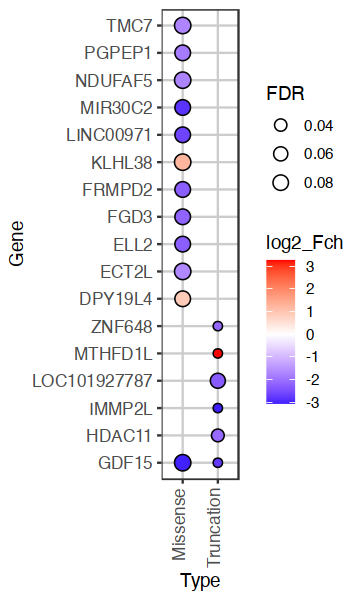

In [14]:
options(repr.plot.width=3, repr.plot.height=5)
p